In [1]:
import random
from typing import Any
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

/home/fdse/anaconda3/envs/dev-py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device(cuda: bool = True, seed: int = 1, torch_deterministic: bool = True, verbose: bool = True) -> Any:
    device = torch.device("cuda:0" if torch.cuda.is_available() and cuda else "cpu")

    if verbose:
        print(f"{'Current device':<16} : {device}")
        print(f"{'Pytorch version':<16} : {torch.__version__}")
        print(f"{'CUDA version':<16} : {torch.version.cuda }")
        print(f"{'cuDNN version':<16} : {torch.backends.cudnn.version()}")
        if torch.cuda.is_available() and cuda:
            print(f"{'Device count':<16} : {torch.cuda.device_count()}")
            print(f"{'Device name':<16} : {torch.cuda.get_device_name(device)}")

    torch.cuda.empty_cache()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = torch_deterministic
    torch.set_default_tensor_type(torch.FloatTensor)
    torch.set_default_dtype(torch.float32)

    return device


device = get_device(cuda=False)

Current device   : cpu
Pytorch version  : 1.13.1+cu117
CUDA version     : 11.7
cuDNN version    : 8500


In [3]:
# Reptile


def update_meta_learning_rate(n_iter, meta_optimizer, meta_iterations, meta_learning_rate):
    new_lr = meta_learning_rate * (1.0 - n_iter / float(meta_iterations))
    for param_group in meta_optimizer.param_groups:
        param_group["lr"] = new_lr


def do_inner_loop_update(model, task, inner_iterations, inner_learning_rate, device):
    fast_model = type(model)().to(device)
    fast_model.load_state_dict(model.state_dict())
    inner_optimizer = torch.optim.SGD(fast_model.parameters(), lr=inner_learning_rate)

    for _ in range(inner_iterations):

        # NOTE: inner train case
        x_arr, y_hat_arr = task.training_set()
        x_tensor = torch.tensor(x_arr[:, None], requires_grad=True, dtype=torch.float32).to(device)
        y_hat_tensor = torch.tensor(y_hat_arr[:, None], requires_grad=True, dtype=torch.float32).to(device)
        y_pred_tensor = fast_model(x_tensor)
        loss = ((y_pred_tensor - y_hat_tensor) ** 2).mean()
        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

    return fast_model


def do_eval(fast_model, task, device):

    # NOTE: inner test case
    x_arr, y_hat_arr = task.test_set()
    x_tensor = torch.tensor(x_arr[:, None], requires_grad=True, dtype=torch.float32).to(device)
    y_hat_tensor = torch.tensor(y_hat_arr[:, None], requires_grad=True, dtype=torch.float32).to(device)
    y_pred_tensor = fast_model(x_tensor)
    loss = ((y_pred_tensor - y_hat_tensor) ** 2).mean()
    return loss.cpu().data.item()


def do_outer_loop_update(model, fast_model, device):
    for p, fast_p in zip(model.parameters(), fast_model.parameters()):
        if p.grad is None:
            p.grad = torch.zeros(p.size(), requires_grad=True).to(device)
        p.grad.data.add_(p.data - fast_p.data)


def train(model, meta_iterations, meta_learning_rate, inner_iterations, inner_learning_rate, task_generator_fn, device):
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=meta_learning_rate)

    train_loss_lst = []
    test_loss_lst = []

    # start train
    for meta_iteration in range(1, meta_iterations + 1):
        # sample task
        task = task_generator_fn()

        # update learning rate of meta optimizer
        update_meta_learning_rate(meta_iteration, meta_optimizer, meta_iterations, meta_learning_rate)

        # sample envs && do fast weight learning
        fast_model = do_inner_loop_update(
            model, task, inner_iterations, inner_learning_rate, device
        )

        # eval
        train_loss = do_eval(fast_model, task, device)

        # update slow weight
        # Inject updates into each .grad
        do_outer_loop_update(model, fast_model, device)

        # Update meta-parameters
        meta_optimizer.step()
        meta_optimizer.zero_grad()

        # validation
        task = task_generator_fn()
        fast_model = do_inner_loop_update(model, task, inner_iterations, inner_learning_rate, device)
        test_loss = do_eval(fast_model, task, device)

        # log
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)

        if meta_iteration % 1000 == 0 or meta_iteration == 1:
            print(
                f"Iteration: {meta_iteration} | AvgTrainML: {np.mean(train_loss_lst):.4f} | AvgTestML: {np.mean(test_loss_lst):.4f}"
            )

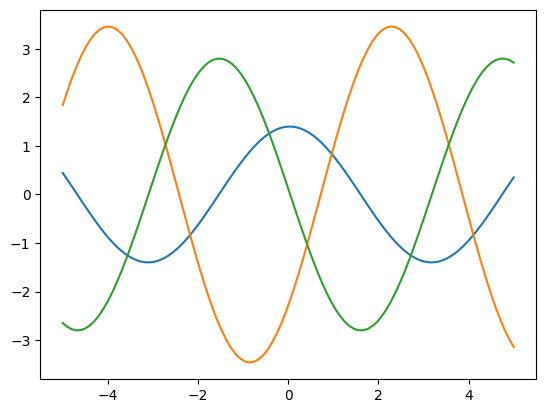

In [4]:
class SineModel(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

        self.main = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
        )

    def forward(self, x):
        return self.main(x)


class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2 * np.pi)
        self.train_x = None

    def f(self, x):
        return self.a * np.sin(x + self.b)

    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return x, y

    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return x, y

    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x, y, *args, **kwargs)

    def plot_model(self, new_model, *args, **kwargs):
        device = kwargs.get("device")
        x, y_true = self.test_set(size=100)
        x = torch.Tensor(x[:, None]).to(device)
        y_true = torch.Tensor(y_true[:, None]).to(device)
        y_pred = new_model(x)
        plt.plot(x.data.cpu().numpy().flatten(), y_pred.cpu().data.numpy().flatten(), *args, **kwargs)


TRAIN_SIZE = 10000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()


def task_genertor():
    return random.sample(SINE_TRAIN, 1)[0]

In [5]:
model = SineModel().to(device)

train(
    model,
    meta_iterations=120000,
    meta_learning_rate=0.001,
    inner_iterations=3,
    inner_learning_rate=0.01,
    task_generator_fn=task_genertor,
    device=device,
)

Iteration: 1 | AvgTrainML: 4.0420 | AvgTestML: 10.8395
Iteration: 1000 | AvgTrainML: 4.3713 | AvgTestML: 4.1674
Iteration: 2000 | AvgTrainML: 4.1430 | AvgTestML: 4.0430
Iteration: 3000 | AvgTrainML: 4.0027 | AvgTestML: 4.0348
Iteration: 4000 | AvgTrainML: 3.8844 | AvgTestML: 3.9390
Iteration: 5000 | AvgTrainML: 3.7888 | AvgTestML: 3.8396
Iteration: 6000 | AvgTrainML: 3.7179 | AvgTestML: 3.7687
Iteration: 7000 | AvgTrainML: 3.6240 | AvgTestML: 3.6610
Iteration: 8000 | AvgTrainML: 3.4885 | AvgTestML: 3.5160
Iteration: 9000 | AvgTrainML: 3.3172 | AvgTestML: 3.3435
Iteration: 10000 | AvgTrainML: 3.1591 | AvgTestML: 3.1811
Iteration: 11000 | AvgTrainML: 3.0063 | AvgTestML: 3.0255
Iteration: 12000 | AvgTrainML: 2.8777 | AvgTestML: 2.9017
Iteration: 13000 | AvgTrainML: 2.7686 | AvgTestML: 2.7935
Iteration: 14000 | AvgTrainML: 2.6686 | AvgTestML: 2.6918
Iteration: 15000 | AvgTrainML: 2.5769 | AvgTestML: 2.6051
Iteration: 16000 | AvgTrainML: 2.4962 | AvgTestML: 2.5211
Iteration: 17000 | AvgTrai

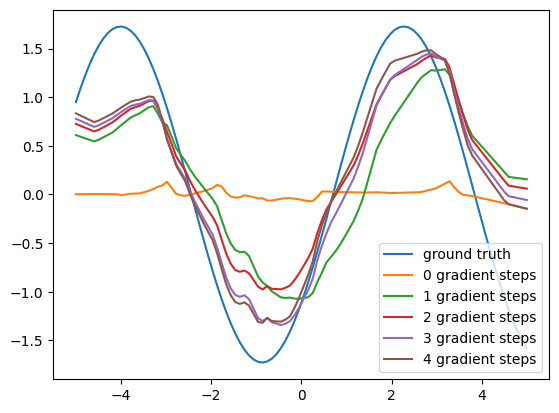

In [6]:
wave = SineWaveTask()
wave.plot(label="ground truth")

# fine-tune
for n_inner_ in range(5):
    new_model = do_inner_loop_update(model, wave, n_inner_, 0.01, device)
    wave.plot_model(new_model, label=f"{n_inner_} gradient steps")

plt.legend()